In [0]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [0]:
data=pd.read_csv('data.csv')

In [0]:
data.head()

,pickups,spd,vsb,temp,dewp,slp,pcp01,pcp06,pcp24,sd,hday,Bronx,Brooklyn,EWR,Manhattan,Queens,Staten Island
0,0.019282,0.238095,1.0,0.321839,0.258427,0.617308,0.0,0.0,0.0,0.0,1,1,0,0,0,0,0
1,0.192693,0.238095,1.0,0.321839,0.258427,0.617308,0.0,0.0,0.0,0.0,1,0,1,0,0,0,0
2,0.000000,0.238095,1.0,0.321839,0.258427,0.617308,0.0,0.0,0.0,0.0,1,0,0,1,0,0,0
3,0.667005,0.238095,1.0,0.321839,0.258427,0.617308,0.0,0.0,0.0,0.0,1,0,0,0,1,0,0
4,0.051376,0.238095,1.0,0.321839,0.258427,0.617308,0.0,0.0,0.0,0.0,1,0,0,0,0,1,0


In [0]:
X = data.drop(['pickups'],axis=1)
Y = data['pickups']
X_train, X_val, Y_train, Y_val  = train_test_split(X, Y, test_size=0.2)

In [0]:
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

In [0]:
regressor = MLPRegressor(hidden_layer_sizes = (100, 75,50,50, 50, 25), activation = 'tanh', solver = 'lbfgs', learning_rate = 'adaptive',alpha = 0.1)
regressor.fit(X_train, Y_train)

MLPRegressor(activation='tanh', alpha=0.1, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100, 75, 50, 50, 50, 25),
             learning_rate='adaptive', learning_rate_init=0.001, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='lbfgs',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [0]:
print(regressor.loss_)

0.003581450449814704


In [0]:
pred_y = regressor.predict(X_val)

print(mean_squared_error(pred_y,Y_val))

0.00548464250288171


In [0]:
clf.best_params_

In [0]:
pred_y = clf.predict(X_val)

print(mean_squared_error(pred_y,Y_val))

In [0]:
%%writefile mlp_gridsearch.py


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.exceptions import ConvergenceWarning
from mpi4py import MPI
import itertools
from math import sqrt
import time

ConvergenceWarning('ignore')


comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

data=pd.read_csv('data.csv')

X = data.drop(['pickups'],axis=1)
Y = data['pickups']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8,test_size=0.2, random_state=1)

X_train, X_val, Y_train, Y_val  = train_test_split(X_train, Y_train, test_size=0.25, random_state=1)

activation = ['tanh','relu']
solver = ['lbfgs','sgd','adam']
alpha=[0.001,0.01,0.1,1]
learning_rate = [0.001,0.0001]
hidden = [(100,50,25),(200,100,100,50),(100,75,50,50)]
para = list(itertools.product(activation,solver,alpha,learning_rate))
block = len(para)//size

start = time.time()

if rank!=size-1:
    parameters = para[rank*block:(rank+1)*block]
    mse = []
    for parameter in parameters:
        mlp = MLPRegressor(hidden_layer_sizes=(100,75,50,50),activation = parameter[0],
                                solver=parameter[1],alpha=parameter[2],learning_rate_init=parameter[3],early_stopping=True,max_iter=200,learning_rate = 'adaptive')
        mlp.fit(X_train, Y_train)
        pred_y = mlp.predict(X_val)
        mse.append(mean_squared_error(pred_y,Y_val))
    index = np.argmin(mse)
    print("rank #",rank,": ",parameters[index],", mse: ",sqrt(mse[index]))
else:
    parameters = para[rank*block:len(para)]
    mse = []
    for parameter in parameters:
        mlp = MLPRegressor(hidden_layer_sizes=(100,75,50,50),activation = parameter[0],
                                solver=parameter[1],alpha=parameter[2],learning_rate_init=parameter[3],early_stopping=True,max_iter=200,learning_rate = 'adaptive')
        mlp.fit(X_train, Y_train)
        pred_y = mlp.predict(X_val)
        mse.append(mean_squared_error(pred_y,Y_val))
    index = np.argmin(mse)
    print("rank #",rank,": ",parameters[index],", mse: ",sqrt(mse[index]))
end = time.time()
print("#",rank,": ",end-start)

Overwriting mlp_gridsearch.py


In [0]:
!mpirun -n 4 python3 mlp_gridsearch.py

//anaconda3/envs/3.6env/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
//anaconda3/envs/3.6env/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
//anaconda3/envs/3.6env/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
rank # 1 :  ('tanh', 'adam', 0.001, 0.0001) , mse:  0.07327842203975819
# 1 :  222.97943210601807
//anaconda3/envs/3.6env/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: Convergence

In [0]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.exceptions import ConvergenceWarning
from mpi4py import MPI
import itertools
from math import sqrt
import time

ConvergenceWarning('ignore')

rank = 0

data=pd.read_csv('data.csv')

X = data.drop(['pickups'],axis=1)
Y = data['pickups']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8,test_size=0.2, random_state=1)

X_train, X_val, Y_train, Y_val  = train_test_split(X_train, Y_train, test_size=0.25, random_state=1)

activation = ['tanh','relu']
solver = ['lbfgs','sgd','adam']
alpha=[0.001,0.01,0.1,1]
learning_rate = [0.001,0.0001]

para = list(itertools.product(activation,solver,alpha,learning_rate))
block = len(para)//size


start = time.time()

if rank == 0:
    mse = []
    for parameter in para:
        mlp = MLPRegressor(hidden_layer_sizes=(100,75,50,50),activation = parameter[0],
                                solver=parameter[1],alpha=parameter[2],learning_rate_init=parameter[3],early_stopping=True,max_iter=200,learning_rate = 'adaptive')
        mlp.fit(X_train, Y_train)
        pred_y = mlp.predict(X_val)
        mse.append(mean_squared_error(pred_y,Y_val))
    index = np.argmin(mse)
    print("rank #",rank,": ",para[index],", mse: ",sqrt(mse[index]))
end = time.time()
print("#",rank,": ",end-start)

//anaconda3/envs/3.6env/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
//anaconda3/envs/3.6env/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
//anaconda3/envs/3.6env/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
//anaconda3/envs/3.6env/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conver

rank # 0 :  ('relu', 'adam', 0.001, 0.0001) , mse:  0.06995688703898462
# 0 :  408.1302111148834


In [0]:
from math import sqrt
regressor = MLPRegressor(hidden_layer_sizes = (100,75,50,25), activation = 'relu', solver = 'adam', alpha=0.001,learning_rate_init=0.001,early_stopping=True,max_iter=1000)
regressor.fit(X_train, Y_train)
pred_y = regressor.predict(X_val)
print(sqrt(mean_squared_error(pred_y,Y_val)))

0.07037176637340148


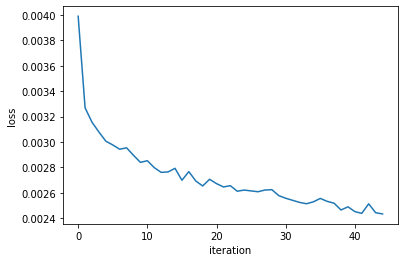

In [0]:
from matplotlib import pyplot as plt
plt.plot(range(len(regressor.loss_curve_)),regressor.loss_curve_)
plt.xlabel("iteration")
plt.ylabel("loss")
#plt.show()
plt.savefig("network_loss.png")

In [0]:
|